# **SOSE Heat & Salt Budgets**

#### From Ryan's code on pangeo.oi/

In [2]:
import xarray as xr
import numpy as np
import dask as dask
import dask.array as dsa
from matplotlib import pyplot as plt
%matplotlib inline
import intake
import pandas as pd
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
import gsw
#import kubernetes
#import yaml

In [3]:
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [4]:
ds = xr.open_zarr('/swot/SUM03/tmp/SOSE')
ds

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
    Depth     (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    PHrefC    (Z) float32 dask.array<shape=(42,), chunksize=(42,)>
    PHrefF    (Zp1) float32 dask.array<shape=(43,), chunksize=(43,)>
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
    drC       (Zp1) float32 dask.ar

In [5]:
ds.ADVr_SLT

<xarray.DataArray 'ADVr_SLT' (time: 438, Zl: 42, YC: 320, XC: 2160)>
dask.array<shape=(438, 42, 320, 2160), dtype=float32, chunksize=(1, 42, 320, 2160)>
Coordinates:
    Depth    (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * Zl       (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
    iter     (time) int64 dask.array<shape=(438,), chunksize=(438,)>
    rA       (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Vertical   Advective Flux of Salinity
    standard_name:  ADVr_SLT
    units:          psu.m^3/s

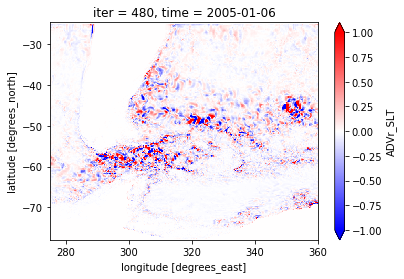

In [6]:
(ds.ADVr_SLT[0].sel(XC=slice(275,360)).mean(dim='Zl')/10e5).plot(cmap='bwr', vmin=-1, vmax=1)

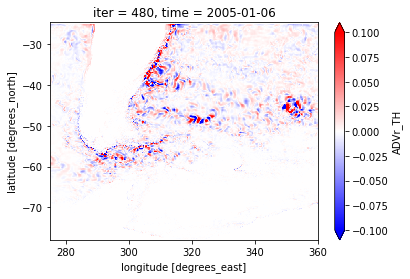

In [7]:
(ds.ADVr_TH[0].sel(XC=slice(275,360)).mean(dim='Zl')/10e5).plot(cmap='bwr', vmin=-0.1, vmax=0.1)

In [8]:
print('Total Size: %6.2F GB' % (ds.nbytes / 1e9))

Total Size: 1408.75 GB


**A trick for optimization:** split the dataset into coordinates and data variables, and then drop the coordinates from the data variables. This makes it easier to align the data variables in arithmetic operations

In [9]:
coords = ds.coords.to_dataset().reset_coords()
dsr = ds.reset_coords(drop=True)
dsr

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables:
    ADVr_SLT  (time, Zl, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 320, 2160)>
    ADVr_TH   (time, Zl, YC, XC) float32 dask.array<shap

In [10]:
coords

<xarray.Dataset>
Dimensions:  (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
  * YG       (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * XG       (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * Zl       (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * Zp1      (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zu       (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
Data variables:
    drC      (Zp1) float32 dask.array<shape=(43,), chunksize=(43,)>
    drF      (Z) float32 dask.array<shape=(42,), chunksize=(42,)>
    iter     (time) int64 dask.array<shape

## Visualize the data
**not working**

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
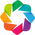

In [11]:
import holoviews as hv
from holoviews.operation.datashader import regrid
hv.extension('bokeh')

In [12]:
hv_image = hv.Dataset(ds.THETA.where(ds.hFacC>0).rename('THETA')).to(hv.Image, kdims=['XC', 'YC'], dynamic=True)
with dask.config.set(scheduler='single-threaded'):
    display(regrid(hv_image, precompute=True))

:DynamicMap   [Z,time]
   :Image   [XC,YC]   (THETA)

## Create XGCM Grid

In [13]:
import xgcm
grid = xgcm.Grid(ds, periodic=('X', 'Y'))
grid

<xgcm.Grid>
T Axis (not periodic):
  * center   time
Y Axis (periodic):
  * center   YC --> left
  * left     YG --> center
X Axis (periodic):
  * center   XC --> left
  * left     XG --> center
Z Axis (not periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center

In [14]:
dsr.var

<bound method ImplementsDatasetReduce._reduce_method.<locals>.wrapped_func of <xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables:
    ADVr_SLT  (time, Zl, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksiz

$$
\mathcal{V}\frac{\partial{S}}{\partial{t}} = G^{S}_{adv} + G^{S}_{diff} + G^{S}_{surf} + G^{S}_{linfs}
$$

$$
\mathcal{V}\frac{\partial{\theta}}{\partial{t}} = G^{\theta}_{adv} + G^{\theta}_{diff} + G^{\theta}_{surf} + G^{\theta}_{linfs}
$$

## Flux Divergence
Define a function (since we need to do it for both tracers) to calculate convergence and diffusive fluxes.

In [15]:
def tracer_flux_budget(suffix):
    """Calculate the convergence of fluxes of tracer `suffix` where
    `suffix` is `TH` or `SLT`. Return a new xarray.Dataset."""
    conv_horiz_adv_flux = -(grid.diff(dsr['ADVx_' + suffix], 'X') + 
                           grid.diff(dsr['ADVy_' + suffix], 'Y')).rename('conv_horiz_adv_flux' + suffix)
    conv_horiz_diff_flux = -(grid.diff(dsr['DFxE_' +suffix], 'X') + 
                            grid.diff(dsr['DFyE_' + suffix], 'Y')).rename('conv_horiz_diff_flux' + suffix)
    
    
    # sign convention is opposite for vertical fluxes
    # Why? If positive then this would imply adv & diff going up?
    conv_vert_adv_flux = grid.diff(dsr['ADVr_' + suffix], 'Z', boundary='fill').rename('conv_vert_adv_flux_' + suffix)
    conv_vert_diff_flux = (grid.diff(dsr['DFrE_' + suffix], 'Z', boundary='fill') +
                           grid.diff(dsr['DFrI_' + suffix], 'Z', boundary='fill') +
                           grid.diff(dsr['KPPg_' + suffix], 'Z', boundary='fill')).rename('conv_vert_diff_flux_' + suffix)

    all_fluxes = [conv_horiz_adv_flux, conv_horiz_diff_flux, conv_vert_adv_flux, conv_vert_diff_flux]
    conv_all_fluxes = sum(all_fluxes).rename('conv_total_flux_' + suffix)

    return xr.merge(all_fluxes + [conv_all_fluxes])

In [16]:
budget_slt = tracer_flux_budget('SLT')
budget_slt

<xarray.Dataset>
Dimensions:                  (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * time                     (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * Z                        (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * YC                       (YC) float32 -77.87497 -77.7083 ... -24.7083
  * XC                       (XC) float32 0.083333336 0.25 ... 359.75 359.9167
Data variables:
    conv_horiz_adv_fluxSLT   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_horiz_diff_fluxSLT  (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_vert_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_vert_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_total_flux_SLT      (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 3

In [17]:
budget_th = tracer_flux_budget('TH')
budget_th

<xarray.Dataset>
Dimensions:                 (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * time                    (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * Z                       (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * YC                      (YC) float32 -77.87497 -77.7083 ... -24.7083
  * XC                      (XC) float32 0.083333336 0.25 ... 359.75 359.9167
Data variables:
    conv_horiz_adv_fluxTH   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_horiz_diff_fluxTH  (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_vert_adv_flux_TH   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_vert_diff_flux_TH  (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_total_flux_TH      (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160),

## Surface Fluxes

In [18]:
# constants
heat_capacity_cp = 3.994e3
runit2mass = 1.035e3

# treat the shortwave flux separately from the rest of the surface flux
surf_flux_th = (dsr.TFLUX - dsr.oceQsw) * coords.rA / (heat_capacity_cp * runit2mass)
surf_flux_th_sw = dsr.oceQsw * coords.rA / (heat_capacity_cp * runit2mass)

# salt
surf_flux_slt = dsr.SFLUX * coords.rA  / runit2mass

lin_fs_correction_th = -(dsr.WTHMASS.isel(Zl=0, drop=True) * coords.rA)
lin_fs_correction_slt = -(dsr.WSLTMASS.isel(Zl=0, drop=True) * coords.rA)

# in order to align the surface fluxes with the rest of the 3D budget terms,
# we need to give them a z coordinate. We can do that with this function
def surface_to_3d(da):
    da.coords['Z'] = dsr.Z[0]
    return da.expand_dims(dim='Z', axis=1) #why only inserting 1 level of 'Z' --> SURFACE FLUX that's why!

In [19]:
dsr.WTHMASS

<xarray.DataArray 'WTHMASS' (time: 438, Zl: 42, YC: 320, XC: 2160)>
dask.array<shape=(438, 42, 320, 2160), dtype=float32, chunksize=(1, 42, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * Zl       (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    standard_name:  WTHMASS
    units:          degC.m/s

In [20]:
dsr.WSLTMASS

<xarray.DataArray 'WSLTMASS' (time: 438, Zl: 42, YC: 320, XC: 2160)>
dask.array<shape=(438, 42, 320, 2160), dtype=float32, chunksize=(1, 42, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * Zl       (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Vertical Mass-Weight Transp of Salinity
    standard_name:  WSLTMASS
    units:          psu.m/s

## Shortwave Flux
special treatment needed for sw since it penetrates into the interior of the ocean.

In [21]:
def swfrac(coords, fact=1., jwtype=2):
    """Clone of MITgcm routine for computing sw flux penetration.
    z: depth of output levels"""

    rfac = [0.58 , 0.62, 0.67, 0.77, 0.78]
    a1 = [0.35 , 0.6  , 1.0  , 1.5  , 1.4]
    a2 = [23.0 , 20.0 , 17.0 , 14.0 , 7.9 ]

    facz = fact * coords.Zl.sel(Zl=slice(0, -200))
    j = jwtype-1
    swdk = (rfac[j] * np.exp(facz / a1[j]) +
            (1-rfac[j]) * np.exp(facz / a2[j]))

    return swdk.rename('swdk')

_, swdown = xr.align(dsr.Zl, surf_flux_th_sw * swfrac(coords), join='left', )
swdown = swdown.fillna(0)

In [22]:
budget_slt

<xarray.Dataset>
Dimensions:                  (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * time                     (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * Z                        (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * YC                       (YC) float32 -77.87497 -77.7083 ... -24.7083
  * XC                       (XC) float32 0.083333336 0.25 ... 359.75 359.9167
Data variables:
    conv_horiz_adv_fluxSLT   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_horiz_diff_fluxSLT  (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_vert_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_vert_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_total_flux_SLT      (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 3

In [23]:
# now we can add the to the budget datasets and they will align correctly
# into the top cell (lazily filling with NaN's elsewhere)
budget_slt['surface_flux_conv_SLT'] = surface_to_3d(surf_flux_slt)
budget_slt['lin_fs_correction_SLT'] = surface_to_3d(lin_fs_correction_slt)
budget_slt

<xarray.Dataset>
Dimensions:                  (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * Z                        (Z) float64 -5.0 -15.5 ... -5.325e+03 -5.575e+03
  * time                     (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * YC                       (YC) float32 -77.87497 -77.7083 ... -24.7083
  * XC                       (XC) float32 0.083333336 0.25 ... 359.75 359.9167
Data variables:
    conv_horiz_adv_fluxSLT   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_horiz_diff_fluxSLT  (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_vert_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_vert_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_total_flux_SLT      (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 3

In [24]:
budget_th

<xarray.Dataset>
Dimensions:                 (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * time                    (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * Z                       (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * YC                      (YC) float32 -77.87497 -77.7083 ... -24.7083
  * XC                      (XC) float32 0.083333336 0.25 ... 359.75 359.9167
Data variables:
    conv_horiz_adv_fluxTH   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_horiz_diff_fluxTH  (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_vert_adv_flux_TH   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_vert_diff_flux_TH  (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_total_flux_TH      (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160),

In [25]:
budget_th['surface_flux_conv_TH'] = surface_to_3d(surf_flux_th)
budget_th['lin_fs_correction_TH'] = surface_to_3d(lin_fs_correction_th)
budget_th['sw_flux_conv_TH'] = -grid.diff(swdown, 'Z', boundary='fill').fillna(0.)
budget_th

<xarray.Dataset>
Dimensions:                 (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * Z                       (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                    (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * YC                      (YC) float32 -77.87497 -77.7083 ... -24.7083
  * XC                      (XC) float32 0.083333336 0.25 ... 359.75 359.9167
Data variables:
    conv_horiz_adv_fluxTH   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_horiz_diff_fluxTH  (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_vert_adv_flux_TH   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_vert_diff_flux_TH  (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_total_flux_TH      (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160),

In [26]:
budget_th['total_tendency_TH'] = (budget_th.conv_total_flux_TH + budget_th.lin_fs_correction_TH.fillna(0) + 
                                  budget_th.surface_flux_conv_TH.fillna(0) + budget_th.sw_flux_conv_TH)
budget_th

<xarray.Dataset>
Dimensions:                 (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * Z                       (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                    (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * YC                      (YC) float32 -77.87497 -77.7083 ... -24.7083
  * XC                      (XC) float32 0.083333336 0.25 ... 359.75 359.9167
Data variables:
    conv_horiz_adv_fluxTH   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_horiz_diff_fluxTH  (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_vert_adv_flux_TH   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_vert_diff_flux_TH  (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_total_flux_TH      (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160),

In [27]:
budget_slt['total_tendency_SLT'] = (budget_slt.conv_total_flux_SLT +
                                    budget_slt.surface_flux_conv_SLT.fillna(0.) +
                                    budget_slt.lin_fs_correction_SLT.fillna(0.))
budget_slt

<xarray.Dataset>
Dimensions:                  (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * Z                        (Z) float64 -5.0 -15.5 ... -5.325e+03 -5.575e+03
  * time                     (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * YC                       (YC) float32 -77.87497 -77.7083 ... -24.7083
  * XC                       (XC) float32 0.083333336 0.25 ... 359.75 359.9167
Data variables:
    conv_horiz_adv_fluxSLT   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_horiz_diff_fluxSLT  (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 319, 2159)>
    conv_vert_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_vert_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 41, 320, 2160)>
    conv_total_flux_SLT      (time, Z, YC, XC) float32 dask.array<shape=(438, 42, 3

In [28]:
volume = (coords.drF * coords.rA * coords.hFacC)
#client.scatter(volume)
day2seconds = (24*60*60)**-1

budget_th['total_tendency_TH_truth'] = dsr.TOTTTEND * volume * day2seconds
budget_slt['total_tendency_SLT_truth'] = dsr.TOTSTEND * volume * day2seconds

## Validate Budget
Vertical and horizontal integrals of budget

In [29]:
#take avg over 10 timesteps
time_slice = dict(time=slice(0, 10))

In [30]:
valid_range = dict(YC=slice(-90,-30))

def check_vertical(budget, suffix):
    ds_chk = (budget[[f'total_tendency_{suffix}', f'total_tendency_{suffix}_truth']]
              .sel(**valid_range).sum(dim=['Z', 'XC']).mean(dim='time'))
    return ds_chk

def check_horizontal(budget, suffix):
    ds_chk = (budget[[f'total_tendency_{suffix}', f'total_tendency_{suffix}_truth']]
              .sel(**valid_range).sum(dim=['YC', 'XC']).mean(dim='time'))
    return ds_chk

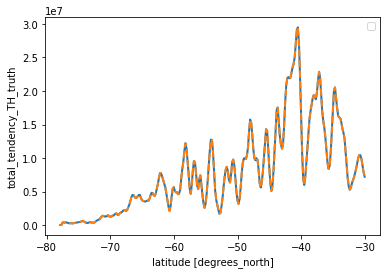

In [31]:
th_vert = check_vertical(budget_th.isel(**time_slice), 'TH').load()
th_vert.total_tendency_TH.plot(linewidth=2)
th_vert.total_tendency_TH_truth.plot(linestyle='--', linewidth=2)
plt.legend()

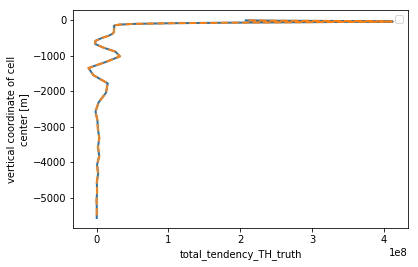

In [32]:
th_horiz = check_horizontal(budget_th.isel(**time_slice), 'TH').load()
th_horiz.total_tendency_TH.plot(linewidth=2, y='Z')
th_horiz.total_tendency_TH_truth.plot(linestyle='--', linewidth=2, y='Z')
plt.legend()

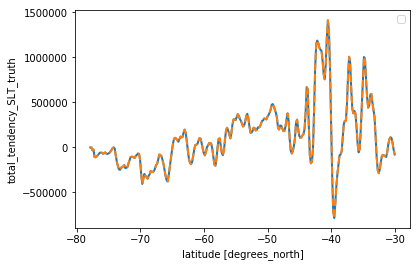

In [33]:
slt_vert = check_vertical(budget_slt.isel(**time_slice), 'SLT').load()
slt_vert.total_tendency_SLT.plot(linewidth=2)
slt_vert.total_tendency_SLT_truth.plot(linestyle='--', linewidth=2)
plt.legend()

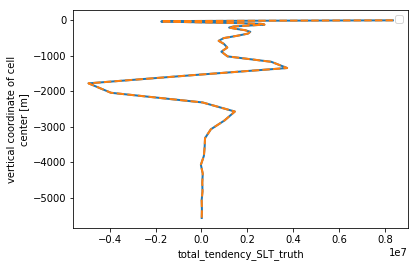

In [34]:
slt_horiz = check_horizontal(budget_slt.isel(**time_slice), 'SLT').load()
slt_horiz.total_tendency_SLT.plot(linewidth=2, y='Z')
slt_horiz.total_tendency_SLT_truth.plot(linestyle='--', linewidth=2, y='Z')
plt.legend()

## Histogram Analysis of Error 
The curves look the same, but how do we know if our error is truly small - compare the distribution of the error $$P(G_{est} - G_{truth})$$ to the distribution of the other terms in the equation, e.g. $$P(G_{adv})$$.

First we try to determine the appropriate range for our histograms by looking at the maximum values.

In [35]:
#The `**` takes the dictionary you created ('time_slice') and executes its contens as params to a function
budget_th.isel(**time_slice).max().load()

<xarray.Dataset>
Dimensions:                  ()
Data variables:
    conv_horiz_adv_fluxTH    float32 19145940.0
    conv_horiz_diff_fluxTH   float32 89941.086
    conv_vert_adv_flux_TH    float32 23173650.0
    conv_vert_diff_flux_TH   float32 534407.7
    conv_total_flux_TH       float32 510076.62
    surface_flux_conv_TH     float32 21228.941
    lin_fs_correction_TH     float32 10248.496
    sw_flux_conv_TH          float32 21346.447
    total_tendency_TH        float32 510076.62
    total_tendency_TH_truth  float32 297048.4

In [36]:
budget_slt.isel(**time_slice).max().load()

<xarray.Dataset>
Dimensions:                   ()
Data variables:
    conv_horiz_adv_fluxSLT    float32 94174560.0
    conv_horiz_diff_fluxSLT   float32 17939.193
    conv_vert_adv_flux_SLT    float32 105942130.0
    conv_vert_diff_flux_SLT   float32 76532.33
    conv_total_flux_SLT       float32 5261500.5
    surface_flux_conv_SLT     float32 7828.6157
    lin_fs_correction_SLT     float32 20308.545
    total_tendency_SLT        float32 5261500.5
    total_tendency_SLT_truth  float32 46110.24

In [37]:
#parameters for histogram calculation:
th_range = (2e-7, 2e7)
slt_range = (2e-8, 2e8)
valid_region = dict(YC=slice(-90,-30))
nbins = 301

In [38]:
# budget errors
error_th = budget_th.total_tendency_TH - budget_th.total_tendency_TH_truth
error_slt = budget_slt.total_tendency_SLT - budget_slt.total_tendency_SLT_truth

In [39]:
# calculate theta error histograms over the whole time range
adv_hist_th, hbins_th = dsa.histogram(budget_th.conv_horiz_adv_fluxTH.sel(**valid_region).data,
                                      bins=nbins, range=th_range)
err_hist_th, hbins_th = dsa.histogram(error_th.sel(**valid_region).data,
                                      bins=nbins, range=th_range)
err_hist_th, adv_hist_th = dask.compute(err_hist_th, adv_hist_th)

In [ ]:
bin_c_th = 0.5*(hbins_th[:-1] + hbins_th[1:])
plt.semilogy(bin_c_th, adv_hist_th, label='Advective Tendency')
plt.semilogy(bin_c_th, err_hist_th, label='Budget Residual')
plt.legend()
plt.title('THETA Budget')

In [ ]:
# calculate salt error histograms over the whole time range
adv_hist_slt, hbins_slt = dsa.histogram(budget_slt.conv_horiz_adv_flux_SLT.sel(**valid_region).data,
                                        bins=nbins, range=slt_range)
err_hist_slt, hbins_slt = dsa.histogram(error_slt.sel(**valid_region).fillna(-9e13).data,
                                        bins=nbins, range=slt_range)
err_hist_slt, adv_hist_slt = dask.compute(err_hist_slt, adv_hist_slt)

In [ ]:
bin_c_slt = 0.5*(hbins_slt[:-1] + hbins_slt[1:])
plt.semilogy(bin_c_slt, adv_hist_slt, label='Advective Tendency')
plt.semilogy(bin_c_slt, err_hist_slt, label='Budget Residual')
plt.title('SALT Budget')
plt.legend()